<p align="center"><h1 align="center">QMSS5074GR <br> Projects in Advanced Machine Learning <br>Spring 2024<br>FINAL PROJECT <br></h1>

<h3 align="center">Yuntian Zhang, Qingxuan Guo <h3>

**The report introduces different approaches to a sentiment classification task.**

## Overview:
1. [Prepare Data](#prepare-data)
2. [Preprocess Data](#preprocess-data)
3. EDA
4. Models & Metrics

## Models included in the report are: 
1. Non Deep Leaning: SVC

Deep Learning:
1. 

Dataset used: Stanford Sentiment Treebank - Movie Review Classification Competition

## 1. Prepare Data

In [ ]:
from aimodelshare import download_data
download_data('public.ecr.aws/y2e2a1d6/sst2_competition_data-repository:latest')


Data downloaded successfully.


In [ ]:
# Set up X_train, X_test, and y_train_labels objects
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=Warning)

X_train=pd.read_csv("sst2_competition_data/X_train.csv")
X_test=pd.read_csv("sst2_competition_data/X_test.csv")
y_train_labels=pd.read_csv("sst2_competition_data/y_train_labels.csv")


X_train.head()

,text
0,The Rock is destined to be the 21st Century 's...
1,The gorgeously elaborate continuation of `` Th...
2,Singer/composer Bryan Adams contributes a slew...
3,Yet the act is still charming here .
4,Whether or not you 're enlightened by any of D...


## 2.   Preprocess Data
Make text lowercase, remove text in square brackets, remove links, remove punctuation, remove words containing numbers, stem, build a Document-Term Matrix (DTM) out of training data and build TF-IDF matrix. 

In [ ]:
def to_series(df):
  ## Complete this function to convert to series if there is only one column, else keep as dataframe. [1 Pts]
  if df.shape[1] == 1:
    df = df.squeeze()
  return df

In [ ]:
import re
import string
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
import nltk
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [ ]:
def clean_data(text):
    text = clean_text(text)
    text = stemm_text(text)
    return text

X_train['text_clean'] = X_train['text'].apply(clean_data)
X_test['text_clean'] = X_test['text'].apply(clean_data)

X_train=to_series(X_train[['text_clean']])
X_test=to_series(X_test[['text_clean']])
y_train_labels=to_series(y_train_labels)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer
vect_tunned = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=10, max_df=200)
vect_tunned.fit(X_train)
x_train_dtm = vect_tunned.transform(X_train)

from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(x_train_dtm)

In [ ]:
# final preprocessor
def preprocessor(data):
  data_dtm = vect_tunned.transform(data)
  data_dtm_tfidf = tfidf_transformer.transform(data_dtm)
  return data_dtm_tfidf

## 3. EDA

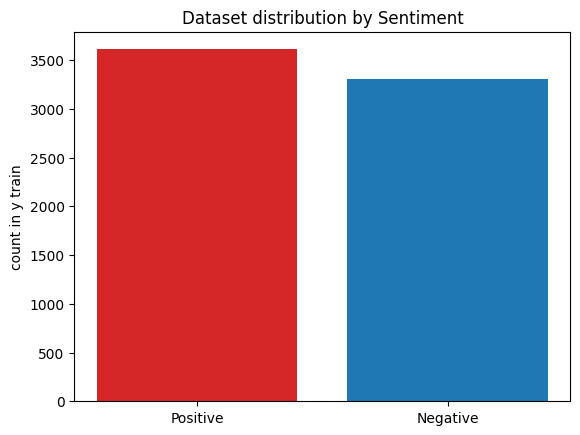

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

balance_train = ['Positive', 'Negative']
counts = [3610, 3310]
bar_colors = ['tab:red', 'tab:blue']

ax.bar(balance_train, counts, color=bar_colors)

ax.set_ylabel('count in y train')
ax.set_title('Dataset distribution by Sentiment')

plt.show()

As we can see, the classes are mostly balanced, so we do not neet to consider using some kind of resampling.

Text(0.5, 1.0, 'Review Length Distribution in X_train')

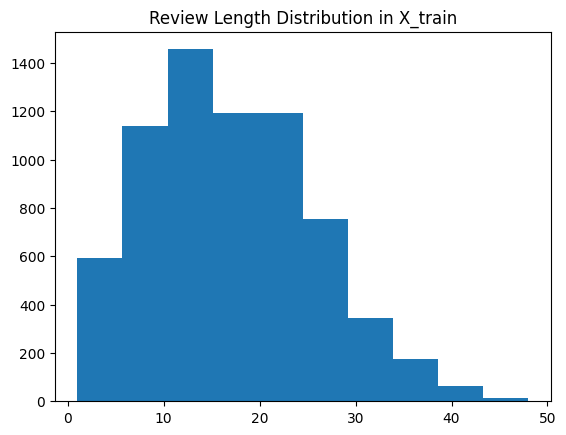

In [ ]:
# review lengths
import matplotlib.pyplot as plt

review_length = X_train.apply(lambda x: len(x.split()))
plt.hist(review_length)
plt.title("Review Length Distribution in X_train")

As shown in this graph, we can see that the review length of X_train varies, with longest review reaching 50 words. Therefore, as we proceed to step two, before buildiing deep learning models, we could consider padding the review into same length.

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


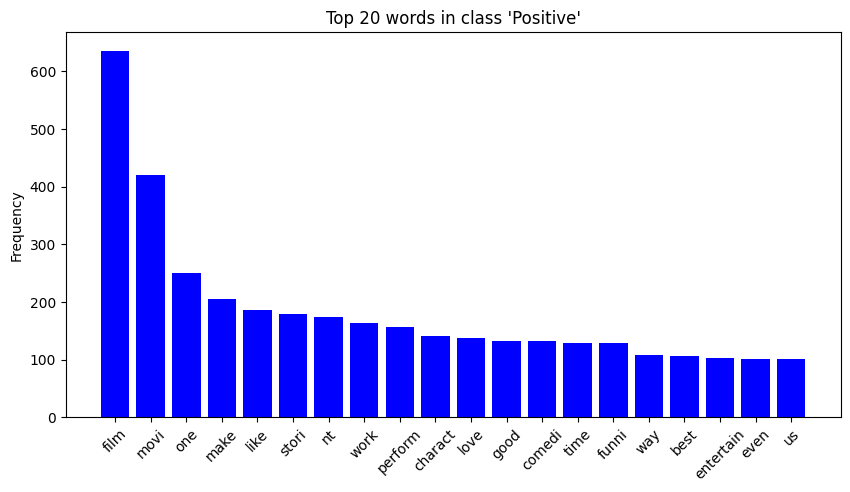

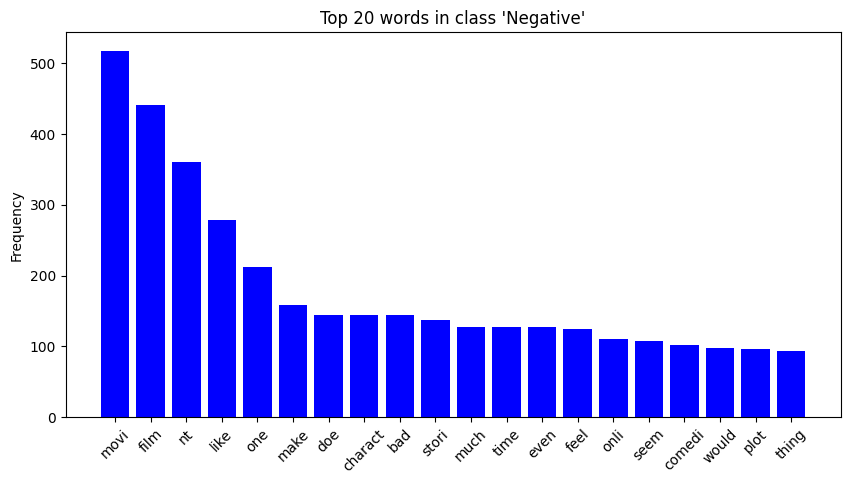

In [ ]:
# word frequency
from nltk.tokenize import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt
nltk.download('punkt')
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# Tokenize and create a freq dict per class
word_freq = {}
classes = y_train_labels.unique()

for class_name in classes:
    text_data = X_train[y_train_labels == class_name]
    all_words = []
    for text in text_data:
        # Tokenize and stop words removal
        tokens = [word for word in word_tokenize(text) if word.lower() not in stop_words and word.isalpha()]
        all_words.extend(tokens)

    word_freq[class_name] = Counter(all_words)

# top N words per class
top_n = 20
for class_name, counter in word_freq.items():
    most_common = counter.most_common(top_n)
    words = [word for word, freq in most_common]
    frequencies = [freq for word, freq in most_common]


    plt.figure(figsize=(10, 5))
    plt.bar(words, frequencies, color='blue')
    plt.title(f"Top {top_n} words in class '{class_name}'")
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

As shown in the bar plots above, word frequency in positive and negative classed corpuses are different to a certain extent.
Both contain theme words like "movie", "film", "story" and "character". Both contain common verbs and prepositions and adverbs like "feel", "like", "make" and "even".
Positive corpuses contain specific words like "funny", "best", etc.
Negative corpuses contain specific words like "bad".


---

Moreover, these plots again proves that setting max_df to 200 is reasonable, because we can exclude words that are common in the context and not helpful to classification like "movie" and "film" which has a max count over 200 in both target classes. As shown in the plots, words below 200 act as a more stronger indicator in target classes like "best", "funny" in positive, "only" in negative.

If you think lemmatization, stemming and other text preprocessing should be performed, code here. You can also go back and include it in the preprocessing function if you want.

You are also free to include any extra features that you extract from the text to aid in modeling (Optional)

## 4. Building Models

### 4.1 Non-deep learning

In [ ]:
# Compare two or more models
data=mycompetition.compare_models([485, 486], verbose=1)
mycompetition.stylize_compare(data)

,param_name,default_value,model_version_485,model_version_486
0,bootstrap,True,True,True
1,ccp_alpha,0.000000,0.000000,0.000000
2,class_weight,None,None,None
3,criterion,gini,gini,gini
4,max_depth,None,None,None
5,max_features,sqrt,sqrt,sqrt
6,max_leaf_nodes,None,None,None
7,max_samples,None,None,None
8,min_impurity_decrease,0.000000,0.000000,0.000000
9,min_samples_leaf,1,1,2


In [ ]:
# Here are several classic ML architectures you can choose from to experiment with next:
from sklearn.svm import SVC

## Experiment with at least 3 different models from above imports. [2 Pts]
X_train_preprocessed = preprocessor(X_train)
X_test_preprocessed = preprocessor(X_test)

modelSVC = SVC()
modelSVC.fit(X_train_preprocessed, y_encoded)

SVC()

In [3]:
! pip install aimodelshare

  Using cached aimodelshare-0.1.11-py3-none-any.whl (975 kB)
  Using cached tf2onnx-1.16.1-py3-none-any.whl (455 kB)
  Using cached docker-5.0.0-py2.py3-none-any.whl (146 kB)
  Using cached onnxconverter_common-1.14.0-py2.py3-none-any.whl (84 kB)
  Using cached importlib_resources-5.10.0-py3-none-any.whl (34 kB)
  Using cached scikit_learn-1.2.2-cp310-cp310-win_amd64.whl (8.3 MB)
  Using cached boto3-1.26.69-py3-none-any.whl (132 kB)
  Using cached pydot-1.3.0-py2.py3-none-any.whl (18 kB)
  Using cached scikeras-0.13.0-py3-none-any.whl (26 kB)
  Using cached onnx-1.13.1-cp310-cp310-win_amd64.whl (12.2 MB)
  Using cached botocore-1.29.82-py3-none-any.whl (10.5 MB)
  Using cached keras2onnx-1.7.0-py3-none-any.whl (96 kB)
  Using cached skl2onnx-1.16.0-py2.py3-none-any.whl (298 kB)
  Using cached Pympler-0.9.tar.gz (178 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached shortuuid-1.0.13-py3-none-any.whl (10 kB)
  Using 

  error: subprocess-exited-with-error
  
  Preparing metadata (pyproject.toml) did not run successfully.
  exit code: 1
  
  [54 lines of output]
  <string>:17: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  Partial import of sklearn during the build process.
  <string>:116: DeprecationWarning:
  
    `numpy.distutils` is deprecated since NumPy 1.23.0, as a result
    of the deprecation of `distutils` itself. It will be removed for
    Python >= 3.12. For older Python versions it will remain present.
    It is recommended to use `setuptools < 60.0` for those Python versions.
    For more details, see:
      https://numpy.org/devdocs/reference/distutils_status_migration.html
  
  
  INFO: No module named 'numpy.distutils._msvccompiler' in numpy.distutils; trying from distutils
  Traceback (most recent call last):
    File "D:\Program Files\anaconda3\lib\site-packages\pip\_vendor\pep517\in_process\_in_process.py", 

In [2]:
import aimodelshare
from aimodelshare.aws import set_credentials

apiurl="https://rlxjxnoql9.execute-api.us-east-1.amazonaws.com/prod/m" #This is the unique rest api that powers this Movie Review Playground

set_credentials(apiurl=apiurl)
import aimodelshare as ai
mycompetition= ai.Competition(apiurl)
# Get raw data in pandas data frame
data = mycompetition.get_leaderboard()

ModuleNotFoundError: No module named 'aimodelshare'

In [ ]:
test_metric = data[data['version'].isin([489, 490, 491, 492, 493, 494])][['model_type', 'accuracy', 'f1_score', 'precision', 'recall']]
test_metric

In [ ]:
def train_data(models, X_train_preprocessed, y_encoded):
  train_df = pd.DataFrame()
  train_df['model_type'] = ['SVC']
  f1_metrics = []
  precision_score_metrics = []
  accuracy_score_metrics = []
  recall_score_metrics = []
  for model in models:
    prediction_labels = model.predict(X_train_preprocessed)
    f1_metric = f1_score(y_encoded, list(prediction_labels))
    precision_score_metric = precision_score(y_encoded, list(prediction_labels))
    accuracy_score_metric = accuracy_score(y_encoded, list(prediction_labels))
    recall_score_metric = recall_score(y_encoded, list(prediction_labels))
    f1_metrics.append(f1_metric)
    precision_score_metrics.append(precision_score_metric)
    accuracy_score_metrics.append(accuracy_score_metric)
    recall_score_metrics.append(recall_score_metric)
  train_df['accuracy_train'] = accuracy_score_metrics
  train_df['f1_train'] = f1_metrics
  train_df['precision_train'] = precision_score_metrics
  train_df['recall_train'] = recall_score_metrics
  return train_df

models = [modelSVC]

train_metric = train_data(models, X_train_preprocessed,y_encoded)
train_metric

In [ ]:
tabularized_model_results = pd.merge(test_metric, train_metric, on="model_type")
tabularized_model_results

,model_type,accuracy,f1_score,precision,recall,accuracy_train,f1_train,precision_train,recall_train
0,SVC,0.765093,0.765011,0.765506,0.765115,0.951156,0.952885,0.959035,0.946814
1,RFClassifier1,0.739846,0.739835,0.739903,0.739854,0.984827,0.985329,0.994080,0.976731
2,RFClassifier2,0.726674,0.726653,0.726763,0.726684,0.891040,0.896684,0.887202,0.906371
3,BaggingClassifier,0.717892,0.717891,0.717902,0.717896,0.967919,0.968794,0.983447,0.954571
4,RFClassifier GridCV,0.621295,0.581788,0.695936,0.621633,0.677023,0.758613,0.621703,0.972853
5,GradientBoostingClassifier,0.635565,0.611440,0.680987,0.635840,0.718353,0.778648,0.659865,0.949584


the SVC has the highest test accuracy, F1 score, precision, and recall. This indicates it is the most consistent across all metrics for the test set, suggesting it might be the best generalizer among the models evaluated for unseen data.

However, for RFClassifier1, despite having slightly lower metrics in the test set, has exceptionally high training metrics, this indicate a risk of overfitting since its performance is much better on the training set than on the test set. This could be due to RF's tendancy of overfitting, since for RFC1 we used defualt hyperparams.

The BaggingClassifier and RFClassifier2 performs moderate but not as good as the SVC or RFClassifier1.

The RFClassifier GridCV and GradientBoostingClassifier have the lowest performance metrics on the test set.

For RFClassifier GridCV, the drop in performance in trainingset compare to RFC1 is substantial, this might be becuase by manuelly setting combinations of hyperparams we want the model to train on, we intentionally set the max_depth can not be greater then 10 to try to solve its overfitting problem.

### 4.2 Deep Learning